In [1]:
# Run the pip install command below if you don't already have the library
# !pip install git+https://github.com/JustAnotherArchivist/snscrape.git

#Sources https://github.com/MartinBeckUT/TwitterScraper/blob/master/snscrape/python-wrapper/snscrape-python-wrapper.ipynb
#https://medium.com/better-programming/how-to-scrape-tweets-with-snscrape-90124ed006af

In [21]:
import pandas as pd
import numpy as np
import re
import snscrape.modules.twitter as sntwitter

In [3]:
#This controls how many quotes to return
#It looks like 109 is the max amount of quotes I can call at once
# n_quotes = str(109)
# url_link = "https://ron-swanson-quotes.herokuapp.com/v2/quotes"
# ron_swanson_quotes_raw = []
# for i in range(9):
#     temp = requests.get(url_link + '/' + n_quotes)
#     ron_swanson_quotes_raw.append(temp.text)
# len(ron_swanson_quotes_raw)
#The seperator looks like this ","
# ron_quotes = [x for sublist in ron_swanson_quotes_raw for x in sublist.split("\",\"")]
# len(ron_quotes)
# ron_unique = list(set(ron_quotes))
# len(ron_unique)

In [4]:
def scrape_twitter_account(account, start_date, end_date, num_tweets):
    temp_str = 'from:' + account + ' since:' + start_date + ' until:' + end_date
    temp_list = []
    for i, tweet in enumerate(sntwitter.TwitterSearchScraper(temp_str).get_items()):
        if i > num_tweets:
            break
        temp_list.append([tweet.date, tweet.id, tweet.content, tweet.user.username])
    return temp_list

In [5]:
#setting the number of tweets I want to return
n_tweets = 3000

#setting what twitter accounts I want to scrape
twitter_accounts = ['AOC', 'SenTedCruz']

#setting time period of tweets to get an accurate comparison
start_date = '2020-01-01'
end_date = '2020-12-01'

# aoc_tweets = scrape_twitter_account(twitter_accounts[0], start_date, end_date, n_tweets)
# cruz_tweets = scrape_twitter_account(twitter_accounts[1], start_date, end_date, n_tweets)

In [6]:
# Creating a dataframe from the tweets list above
aoc_df = pd.DataFrame(aoc_tweets, columns=['Datetime', 'Tweet Id', 'Text', 'Username'])
cruz_df = pd.DataFrame(cruz_tweets, columns=['Datetime', 'Tweet Id', 'Text', 'Username'])

print(aoc_df.shape)
print(cruz_df.shape)

(1309, 4)
(2608, 4)


In [7]:
aoc_df['Month'] = aoc_df['Datetime'].dt.month
cruz_df['Month'] = cruz_df['Datetime'].dt.month

In [8]:
#Saving the dataframes as csv so I dont have to scrape everytime
aoc_df.to_csv(r"C:\Users\cherndon\python_practice\Final Project\aoc tweets.csv")
cruz_df.to_csv(r"C:\Users\cherndon\python_practice\Final Project\cruz tweets.csv")

In [9]:
aoc_df

,Datetime,Tweet Id,Text,Username,Month
0,2020-11-28 17:31:42+00:00,1332738952504238085,Grateful to all who joined us last night!\n\nW...,AOC,11
1,2020-11-28 05:55:54+00:00,1332563850743386114,We did it!\n\n$200k raised in one livestream (...,AOC,11
2,2020-11-28 05:44:28+00:00,1332560973933277184,:),AOC,11
3,2020-11-28 03:21:40+00:00,1332525034632515585,@Corpse_Husband DM if you need his contact info,AOC,11
4,2020-11-28 03:20:52+00:00,1332524836518813697,@Corpse_Husband Hasan says he can’t reach you!,AOC,11
...,...,...,...,...,...
1304,2020-01-03 19:52:29+00:00,1213186386607689729,War advocates start off saying “we all want pe...,AOC,1
1305,2020-01-03 19:49:32+00:00,1213185646665371649,Right now is the moment to decide if you are p...,AOC,1
1306,2020-01-03 19:46:40+00:00,1213184923626070017,Last night the President engaged in what is wi...,AOC,1
1307,2020-01-02 23:54:38+00:00,1212884939122905088,This is just the beginning of our new climate ...,AOC,1


<AxesSubplot:xlabel='Month'>

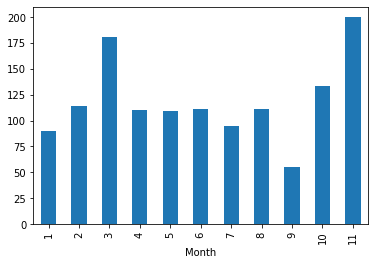

In [10]:
aoc_df.groupby('Month')['Tweet Id'].count().plot.bar()

<AxesSubplot:xlabel='Month'>

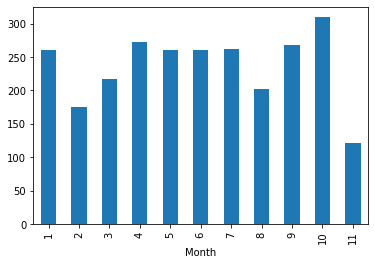

In [11]:
cruz_df.groupby('Month')['Tweet Id'].count().plot.bar()

In [18]:
tweets = ['@joe123 thank you', 'this reminds me of @john12', 'this tweet has no username tag in it']

clean_tweets = [word for tweet in tweets for word in tweet.split() if not word.startswith('@')]

In [19]:
clean_tweets

['thank',
 'you',
 'this',
 'reminds',
 'me',
 'of',
 'this',
 'tweet',
 'has',
 'no',
 'username',
 'tag',
 'in',
 'it']

In [20]:

[re.sub(r'\s*@\w+\s*', '', x) for x in tweets]

['thank you', 'this reminds me of', 'this tweet has no username tag in it']

In [ ]:
[re.sub(r'@\w+', '', x) for x in tweets]